In [ ]:
!pip install magenta

In [3]:
from matplotlib  import pyplot as plt
%config InlineBackend.figure_format = 'retina'

from functools        import reduce
from h5py             import File
from glob             import glob
from os               import makedirs
from os.path          import exists, isdir
from pandas           import read_csv
from scipy.io.wavfile import read as readWave

import numpy       as np
import librosa     as lbr

from magenta.music.audio_io      import int16_samples_to_float32, crop_samples
from magenta.music.midi_io       import midi_file_to_note_sequence
from magenta.music.sequences_lib import sequence_to_pianoroll, apply_sustain_control_changes
from magenta.models.onsets_frames_transcription.audio_label_data_utils import find_split_points # file name changed to 'audio_label_data_utils' 

# Dataset: MAESTRO (MIDI and Audio Edited<br>for Synchronous TRacks and Organization)
Downloaded from Google Magenta: https://magenta.tensorflow.org/datasets/maestro#download
## Warning
For some samples last midi note onsets are slightly beyond the duration of the corresponding WAV-audio.


# Not used datasets

## Not used: MAPS (from Fichiers - Aix-Marseille Université)
https://amubox.univ-amu.fr/index.php/s/iNG0xc5Td1Nv4rR

### Issue 1 (small dataset and not as natural)
From https://arxiv.org/pdf/1810.12247.pdf, Page 4, Section 3 "Dataset":

`MAPS ... “performances” are not as natural as the MAESTRO performances captured from live performances.  In addition, synthesized audio makes up a large fraction of the MAPS dataset.`

### Issue 2 (skipped notes)
From https://arxiv.org/pdf/1710.11153.pdf, Page 6, Section 6 "Need for more data, more rigorous evaluation":

`In addition to the small number of the MAPS Disklavier recordings, we have also noticed several cases where the Disklavier appears to skip some notes played at low velocity. For example, at the beginning of the Beethoven Sonata No. 9, 2nd movement, several Ab notes played with MIDI velocities in the mid-20s are clearly missing from the audio...`

### Issue 3 (two chords instead of one)

There is an issue with datasets __*"ENSTDkAm"*__ & __*"ENSTDkCl"*__, subtypes __*"RAND"*__ & __*"UCHO"*__.  They are assumed to have only one chord per one WAV-file.  But sometimes the chord is split into two onset times in corresponding MIDI and TXT-files, and those two onset times fall into two consecutive time-frames of cqt-transform (or mel-transform).

## Not used: MusicNET (from University of Washington Computer Science & Engineering)
https://homes.cs.washington.edu/~thickstn/musicnet.html

From https://arxiv.org/pdf/1810.12247.pdf, Page 4, Section 3 "Dataset":

`As discussed in Hawthorne et al. (2018), the alignment between audio and score is not fully accurate.  One advantage of MusicNet is that it contains instruments other than piano` ... `and a wider variety of recording environments.`

# Train/Test Split

From https://arxiv.org/pdf/1810.12247.pdf, Page 4, Section 3.2 "Dataset Splitting":

1. `No composition should appear in more than one split.`


2. `... proportions should be true globally and also within each composer.  Maintaining these proportions is not always possible because some composers have too few compositions in the dataset.`


3. `The validation and test splits should contain a variety of compositions.  Extremely popular compositions performed by many performers should be placed in the training split.`


4. `... we recommend using the splits which we have provided.`

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Downloading maestro dataset

#!wget https://storage.googleapis.com/magentadata/datasets/maestro/v1.0.0/maestro-v1.0.0.zip

--2021-06-30 15:31:23--  https://homes.cs.washington.edu/~thickstn/media/musicnet_midis.tar.gz
Resolving homes.cs.washington.edu (homes.cs.washington.edu)... 128.208.3.226, 2607:4000:200:12::e2
Connecting to homes.cs.washington.edu (homes.cs.washington.edu)|128.208.3.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2601302 (2.5M) [application/x-gzip]
Saving to: ‘musicnet_midis.tar.gz’

musicnet_midis.tar. 100%[===================>]   2.48M  7.59MB/s    in 0.3s    

2021-06-30 15:31:24 (7.59 MB/s) - ‘musicnet_midis.tar.gz’ saved [2601302/2601302]



In [ ]:
#!unzip maestro-v1.0.0.zip -d /content/drive/MyDrive/Maestro

In [ ]:
#Set the directory to Musicnet dataset only with string instruments

dataFolder = '/content/drive/MyDrive/Musicnet/string'

NotExists = lambda song, name: not exists('{} {}.npy'.format(song, name))

df = read_csv(dataFolder + '/string.csv', verbose=True)
df

Tokenization took: 0.26 ms
Type conversion took: 1.19 ms
Parser memory cleanup took: 0.01 ms


,Unnamed: 0,audio_filename,midi_filename,split
0,0,/content/drive/MyDrive/Musicnet/string/wav/193...,/content/drive/MyDrive/Musicnet/string/midi2/1...,test
1,1,/content/drive/MyDrive/Musicnet/string/wav/210...,/content/drive/MyDrive/Musicnet/string/midi2/2...,test
2,2,/content/drive/MyDrive/Musicnet/string/wav/210...,/content/drive/MyDrive/Musicnet/string/midi2/2...,test
3,3,/content/drive/MyDrive/Musicnet/string/wav/210...,/content/drive/MyDrive/Musicnet/string/midi2/2...,test
4,4,/content/drive/MyDrive/Musicnet/string/wav/211...,/content/drive/MyDrive/Musicnet/string/midi2/2...,test
...,...,...,...,...
117,117,/content/drive/MyDrive/Musicnet/string/wav/191...,/content/drive/MyDrive/Musicnet/string/midi2/1...,train
118,118,/content/drive/MyDrive/Musicnet/string/wav/192...,/content/drive/MyDrive/Musicnet/string/midi2/1...,train
119,119,/content/drive/MyDrive/Musicnet/string/wav/192...,/content/drive/MyDrive/Musicnet/string/midi2/1...,train
120,120,/content/drive/MyDrive/Musicnet/string/wav/193...,/content/drive/MyDrive/Musicnet/string/midi2/1...,train


In [ ]:
df2 = read_csv('/content/drive/MyDrive/Maestro/maestro-v1.0.0/maestro-v1.0.0.csv')

In [ ]:
df2['split'].value_counts()

train         954
test          125
validation    105
Name: split, dtype: int64

# Mel-transform parameters
Don't know why not use Constant-Q transform, but from https://arxiv.org/pdf/1710.11153.pdf, Page 2, Section 3 "Model Configuration":

`We use librosa` ... `to compute the same input data representation of mel-scaled spectrograms with log amplitude of the input raw audio with 229 logarithmically-spaced frequency bins, a hop length of 512, an FFT window of 2048, and a sample rate of 16kHz.`

From https://arxiv.org/pdf/1810.12247.pdf, Page 5, Section 4 "Piano Transcription":

`switched to HTK frequency spacing (Young et al., 2006) for the mel-frequency spectrogram input.`

Mel-frequency values are strange:

$f_{min} = 30 Hz$, but the first "A" note of 1st octave is *27.5 Hz*

$f_{max} = 11 025 Hz$ (librosa default), and it is much higher than the last "C" note of 8th octave (*4 186 Hz*).  So, mel-spectrogram will contain lots of high harmonics, and maybe, it will help the CNN-model correctly identify notes in the last octaves.

Maybe (don't know) Mel-scaled spectrogram is used instead of Constant-Q transform, because CQT-transform produces equal number of bins for each note, while mel-frequencies are located such that there are more nearby frequencies for higher notes.  So, mel-spectrogram provides more input data for higher octaves, and the CNN-model can transcribe higher notes with better accuracy.  It can help solve the issue with lots of annoying false-positive notes in high octaves.

## Additional non-linear logarithmic scaling
librosa.power_to_db, ref=1 (default) --> mels decibels are approximately in range *[-40 ... +40]*

# MIDI Pre-Processing
From https://arxiv.org/pdf/1710.11153.pdf

Page 2, Section 2 "Dataset and Metrics":

`... we first translate “sustain pedal” control changes into longer note durations.  If a note is active when sustain goes on, that note will be extended until either sustain goes off or the same note is played again.`

Page 3, Section 3, "Model Configuration":

`... all onsets will end up spanning exactly two frames.  Labeling only the frame that contains the exact beginning of the onset does not work as well because of possible mis-alignments of the audio and labels.  We experimented with requiring a minimum amount of time a note had to be present in a frame before it was labeled, but found that the optimum value was to include any presence.`

# Number of time-frames: 625 + 1 (20 seconds at sample rate of 16 kHz)
From https://arxiv.org/pdf/1710.11153.pdf, Page 2, Section 3 "Model Configuration":

`... we split the training audio into smaller files.  However, when we do this splitting we do not want to cut the audio during notes because the onset detector would miss an onset while the frame detector would still need to predict the note’s presence.  We found that 20 second splits allowed us to achieve a reasonable batch size during training of at least 8, while also forcing splits in only a small number of places where notes are active.`

In [ ]:
#Spliiting training data set into fragment

rate, minSecs, maxSecs, melsMinMin, melsMinMax, melsMeanMin, melsMeanMax, melsMaxMin, melsMaxMax \
    = 16_000, 5, 20, -40, -40, -0, -0, 40, 40
nFrames = lbr.time_to_frames(maxSecs, rate) + 1

errorfiles = []
for i, song in enumerate(glob(dataFolder + '/*/*.wav')):
    songFile = song.split('/')[-1]
    print(songFile)
    csvRow = df.loc[(df['audio_filename'] == song)]
    split = csvRow['split'].to_list()
    assert len(split) == 1, 'CSV train/test split is incorrect'
    split = split[0]
    if not isdir('{}/{}'.format(dataFolder, split)): makedirs('{}/{}'.format(dataFolder, split))
    print('{} of {}\t{}\t{}'.format(i + 1, len(glob(dataFolder + '/*/*.wav')), split, song))

    if any(list(map(lambda name: NotExists('{}/{}/{}'.format(dataFolder, split, songFile[:-4]), name),
                    ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes']))):
        ######################################################################################################
        # From https://github.com/tensorflow/magenta/blob/master/magenta/music/audio_io.py
        nativeRate, y = readWave(song)
        if y.dtype == np.int16: y = int16_samples_to_float32(y)
        elif y.dtype != np.float32: raise AudioIOError('WAV file not 16-bit or 32-bit float PCM, unsupported')
        
        if y.ndim == 2 and y.shape[1] == 2: y = lbr.to_mono(y.T)
        if nativeRate != rate: y = lbr.resample(y, nativeRate, rate)
        
        ######################################################################################################
        # From https://github.com/tensorflow/magenta/blob/master/magenta/models/onsets_frames_transcription/split_audio_and_label_data.py
        # def process_record(..., min_length=5, max_length=20, sample_rate=16000,
        #     allow_empty_notesequence=False, load_audio_with_librosa=False)
        
        samples = lbr.util.normalize(y)
        sequence = apply_sustain_control_changes(midi_file_to_note_sequence(df[df['audio_filename'] == song]['midi_filename'].to_list()[0]))
        roll = sequence_to_pianoroll(sequence, 1 / lbr.frames_to_time(1, rate), 21, 108,
                                      onset_length_ms=32, offset_length_ms=32, onset_mode='length_ms')
        splits = [0, sequence.total_time] if split == 'test' else \
            find_split_points(sequence, samples, rate, minSecs, maxSecs)

        mels, onsets, offsets, actives, volumes = [], [], [], [], []
        for i, (start, end) in enumerate(zip(splits[:-1], splits[1:])):
            print('\tFragment {} of {}'.format(i + 1, len(splits) - 1), end='\t')
            if end - start < minSecs:
                if i not in [0, len(splits) - 2]: print('WARNING: ', end='')
                print('Skipping short sequence < {} seconds'.format(minSecs))
                continue
   
            # Resampling in crop_wav_data is really slow, and we have already done it once, avoid doing it twice:
            newMels = lbr.power_to_db(lbr.feature.melspectrogram(samples if start == 0
                    and end == sequence.total_time else crop_samples(samples, rate, start, end - start),
                rate, n_mels=229, fmin=30, htk=True).astype(np.float32).T).astype(np.float16)
            newOnsets, newOffsets, newActives, newVolumes = map(lambda arr:arr[
                    lbr.time_to_frames(start + lbr.frames_to_time(1, rate) / 2, rate) :
                    lbr.time_to_frames(  end + lbr.frames_to_time(1, rate) / 2, rate) + 1],
                [roll.onsets, roll.offsets, roll.active, roll.onset_velocities])
            if split != 'test':
                if len(newOnsets) == len(newMels) + 1: newOnsets, newOffsets, newActives, newVolumes \
                    = newOnsets[:-1], newOffsets[:-1], newActives[:-1], newVolumes[:-1]
                elif len(newMels) == len(newOnsets) + 1: newMels = newMels[:-1]
            elif len(newOnsets) < len(newMels): newMels = newMels[:len(newOnsets)]
            try:
              assert len(newOnsets) == len(newMels), \
              'Spectrogram duration is different from piano rolls durations'
            except:
              print('Spectrogram duration is different from piano rolls duration, skip')
              errorfiles.append(songFile + ' Fragment {} of {}'.format(i + 1, len(splits) - 1))
              break

            if not newOnsets.sum():
                if i not in [0, len(splits) - 2]: print('WARNING: ', end='')
                print('Skipping empty sequence')
                continue
            
            ########################################################################################################
            # Unfortunately, magenta.music.sequences_lib.extract_subsequence does not take the correct time interval
            # So, we have to manually remove notes which started before the interval:
            for note in newActives[0].nonzero()[0]:
                for i, act in enumerate(newActives):
                    if newOnsets[i][note] or not act[note]: break
                    newActives[i][note] = 0
            ########################################################################################################

            if split != 'test': newMels, newOnsets, newOffsets, newActives, newVolumes = map(
                lambda arr: np.pad(arr, [(0, nFrames - len(arr)), (0, 0)], 'minimum' if arr is newMels \
                else 'constant'), [newMels, newOnsets, newOffsets, newActives, newVolumes])
            assert newMels.shape[:-1] == newOnsets.shape[:-1] == newOffsets.shape[:-1]        \
                    == newActives.shape[:-1] == newVolumes.shape[:-1]                          \
                and newOnsets.shape == newOffsets.shape == newActives.shape == newVolumes.shape \
                and newOnsets.shape[1] == 88 and newMels.shape[1] == 229, 'Wrong data shape'
            mels, onsets, offsets, actives, volumes = map(lambda arr, newArr: arr + [newArr],
                [mels, onsets, offsets, actives, volumes], [newMels, newOnsets, newOffsets, newActives, newVolumes])
            print()
        
        for name, arr in zip(['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'],
                              [mels, onsets, offsets, actives, volumes]):
            np.save('{}/{}/{} {}'.format(dataFolder, split, songFile[:-4], name), arr)
    print()
'All pieces have been processed'

1742.wav
1 of 122	train	/content/drive/MyDrive/Musicnet/string/wav/1742.wav
	Fragment 1 of 57	
	Fragment 2 of 57	
	Fragment 3 of 57	
	Fragment 4 of 57	
	Fragment 5 of 57	
	Fragment 6 of 57	
	Fragment 7 of 57	
	Fragment 8 of 57	
	Fragment 9 of 57	
	Fragment 10 of 57	
	Fragment 11 of 57	
	Fragment 12 of 57	
	Fragment 13 of 57	
	Fragment 14 of 57	
	Fragment 15 of 57	
	Fragment 16 of 57	
	Fragment 17 of 57	
	Fragment 18 of 57	
	Fragment 19 of 57	
	Fragment 20 of 57	
	Fragment 21 of 57	
	Fragment 22 of 57	
	Fragment 23 of 57	
	Fragment 24 of 57	
	Fragment 25 of 57	
	Fragment 26 of 57	
	Fragment 27 of 57	
	Fragment 28 of 57	
	Fragment 29 of 57	
	Fragment 30 of 57	
	Fragment 31 of 57	
	Fragment 32 of 57	
	Fragment 33 of 57	
	Fragment 34 of 57	
	Fragment 35 of 57	
	Fragment 36 of 57	
	Fragment 37 of 57	
	Fragment 38 of 57	
	Fragment 39 of 57	
	Fragment 40 of 57	
	Fragment 41 of 57	
	Fragment 42 of 57	
	Fragment 43 of 57	
	Fragment 44 of 57	
	Fragment 45 of 57	
	Fragment 46 of 57	
	Fragment 47 

'All pieces have been processed'

validation set 1932.wav는 에러로 처리 못함 
nativeRate, y = readWave(song)
  
  ValueError: buffer size must be a multiple of element size

In [ ]:
#Combine prerprocessed data by year

for splitFolder in ['train', 'test', 'validation']:
    print(splitFolder)
    for yearFolder in glob('{}/{}/*//'.format(dataFolder, 'train')):
      yearFolder = int(yearFolder.split('/')[-2])
      print('\t', yearFolder, end='\n\n')
      mels, onsets, offsets, actives, volumes = [], [], [], [], []
      for i, [newMels, newOnsets, newOffsets, newActives, newVolumes] in enumerate(zip(*(
              glob('{}/{}/{}/*{}.npy'.format(dataFolder, splitFolder, yearFolder, arr))
              for arr in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes']))):
          song = newMels.split(' ')[0]
          assert song == newOnsets.split(' ')[0] == newOffsets.split(' ')[0] == newActives.split(' ')[0] \
              == newVolumes.split(' ')[0], 'Inconsistent number of numpy arrays'
          print('{} of {}'.format(i + 1, len(glob('{}/{}/{}/*Actives.npy'.format(
              dataFolder, splitFolder, yearFolder)))), end='\t')
          newMels, newOnsets, newOffsets, newActives, newVolumes = map(
              lambda arr: np.load(arr, allow_pickle=True), [newMels, newOnsets, newOffsets, newActives, newVolumes])
          mels, onsets, offsets, actives, volumes = map(lambda arr, newArr: (arr + newArr.tolist())
              if splitFolder == 'test' else np.vstack([arr, newArr]) if len(arr) else newArr,
              [mels, onsets, offsets, actives, volumes], [newMels, newOnsets, newOffsets, newActives, newVolumes])
          print(song) 
          if splitFolder != 'test':
              mels, volumes = map(lambda arr: arr.astype(np.float16), [mels, volumes])
              onsets, offsets, actives = map(lambda arr: arr.astype(np.int8), [onsets, offsets, actives])
          for name, arr in zip(['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'], [mels, onsets, offsets, actives, volumes]):
              np.save('{}/{}/{} {}'.format(dataFolder, splitFolder, yearFolder, name), arr)
          print('\n', len(actives), 'samples')
          
          melsFlat, volsFlat = map(np.concatenate, [mels, volumes])
          print('Mels decibels           in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(
              melsFlat.min(), melsFlat.mean(), melsFlat.max()))
          # assert melsMinMin < melsFlat.min() < melsMinMax and melsMeanMin < melsFlat.mean() < melsMeanMax \
          #     and melsMaxMin < melsFlat.max() < melsMaxMax, 'Wrong mels decibels range'

          print('Midi normalized volumes in range [{} ... {:.4f} ... {:.2f}]\n'.format(
              volsFlat.min(), volsFlat.mean(), volsFlat.max()))
          for arr in map(np.concatenate, [onsets, offsets, actives]): assert ((arr == 0) | (arr == 1)).all(), \
                  'Onsets, offsets and actives must be only zeros and ones'
          assert volsFlat.min() == 0 and 0 < volsFlat.max() <= 1, 'Wrong normalized MIDI volumes range'

    print(splitFolder, 'saved\n')
'All years combined'

train
	 2017

1 of 113	/content/drive/MyDrive/Maestro/maestro-v1.0.0//train/2017/MIDI-Unprocessed_044_PIANO044_MID--AUDIO-split_07-06-17_Piano-e_1-04_wav--3

 7 samples
Mels decibels           in range [-48 ... -22 ... 35]
Midi normalized volumes in range [0.0 ... 0.0065 ... 0.89]

2 of 113	/content/drive/MyDrive/Maestro/maestro-v1.0.0//train/2017/MIDI-Unprocessed_042_PIANO042_MID--AUDIO-split_07-06-17_Piano-e_1-02_wav--2

 13 samples
Mels decibels           in range [-49 ... -20 ... 35]
Midi normalized volumes in range [0.0 ... 0.0058 ... 0.89]

3 of 113	/content/drive/MyDrive/Maestro/maestro-v1.0.0//train/2017/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1

 22 samples
Mels decibels           in range [-50 ... -23 ... 37]
Midi normalized volumes in range [0.0 ... 0.0045 ... 0.89]

4 of 113	/content/drive/MyDrive/Maestro/maestro-v1.0.0//train/2017/MIDI-Unprocessed_043_PIANO043_MID--AUDIO-split_07-06-17_Piano-e_1-03_wav--3

 28 samples
Mels decibels        

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)



 2 samples
Mels decibels           in range [-45 ... -27 ... 36]
Midi normalized volumes in range [0.0 ... 0.0026 ... 0.77]

3 of 14	/content/drive/MyDrive/Maestro/maestro-v1.0.0//test/2017/MIDI-Unprocessed_050_PIANO050_MID--AUDIO-split_07-06-17_Piano-e_3-01_wav--4

 3 samples
Mels decibels           in range [-45 ... -29 ... 36]
Midi normalized volumes in range [0.0 ... 0.0030 ... 0.88]

4 of 14	/content/drive/MyDrive/Maestro/maestro-v1.0.0//test/2017/MIDI-Unprocessed_053_PIANO053_MID--AUDIO-split_07-06-17_Piano-e_3-04_wav--1

 4 samples
Mels decibels           in range [-46 ... -28 ... 36]
Midi normalized volumes in range [0.0 ... 0.0029 ... 0.88]

5 of 14	/content/drive/MyDrive/Maestro/maestro-v1.0.0//test/2017/MIDI-Unprocessed_057_PIANO057_MID--AUDIO-split_07-07-17_Piano-e_1-07_wav--3

 5 samples
Mels decibels           in range [-46 ... -28 ... 36]
Midi normalized volumes in range [0.0 ... 0.0027 ... 0.88]

6 of 14	/content/drive/MyDrive/Maestro/maestro-v1.0.0//test/2017/MIDI-Unp

'All years combined'

In [ ]:
#Combine prerprocessed data by splits(train, validation, split)

with File(dataFolder + '/Mels train.hdf5', 'w') as f: #, rdcc_nbytes=1024**3*4) as f: # 4 GB cache size
    for splitFolder in ['train', 'validation']:
        print(splitFolder)
        mels, onsets, offsets, actives, volumes = [], [], [], [], []
        for i, [newMels, newOnsets, newOffsets, newActives, newVolumes] in enumerate(zip(*(glob('{}/{}/*{}.npy'.format(
                dataFolder, splitFolder, arr)) for arr in ['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes']))):
            song = newOnsets.split(' ')[0]
            assert song == newOffsets.split(' ')[0] == newActives.split(' ')[0] == newVolumes.split(' ')[0], \
                'Inconsistent number of numpy arrays'
            print('{} of {}'.format(i + 1, len(glob('{}/{}/*Actives.npy'.format(
                dataFolder, splitFolder)))), end='\t')

            newMels, newOnsets, newOffsets, newActives, newVolumes = map(
                lambda arr: np.load(arr, allow_pickle=True), [newMels, newOnsets, newOffsets, newActives, newVolumes])
            
            if splitFolder == 'train':
                # Memory Error, so at first collect data in resisable HDF5-file, then it can be re-saved to NumPy-file
                if not mels: mels = f.create_dataset('Mels', data=newMels,
                    maxshape=(None, newMels.shape[1], newMels.shape[2])) # chunks=True
                else:
                    mels.resize((len(mels) + len(newMels), mels.shape[1], mels.shape[2]))
                    mels[-len(newMels):] = newMels
            else: mels = (mels + newMels.tolist()) if splitFolder == 'test' \
                else np.vstack([mels, newMels]) if len(mels) else newMels

            onsets, offsets, actives, volumes = map(lambda arr, newArr: (arr + newArr.tolist())
                if splitFolder == 'test' else np.vstack([arr, newArr]) if len(arr) else newArr,
                [onsets, offsets, actives, volumes], [newOnsets, newOffsets, newActives, newVolumes])

            print(song)

        for name, arr in zip(['Mels', 'Onsets', 'Offsets', 'Actives', 'Volumes'], [mels, onsets, offsets, actives, volumes]):
            np.save('{}/{} {}'.format(dataFolder, name, splitFolder), arr)
        print('\n', len(actives), 'samples')
        
        melsFlat, volsFlat = map(np.concatenate, [mels, volumes])
        melsMin, melsMean, melsMax = np.min(melsFlat), np.mean(melsFlat), np.max(melsFlat)
        print('Mels decibels           in range [{:.0f} ... {:.0f} ... {:.0f}]'.format(melsMin, melsMean, melsMax))
        # assert melsMinMin < melsMin < melsMinMax and melsMeanMin < melsMean < melsMeanMax \
        #     and melsMaxMin < melsMax < melsMaxMax, 'Wrong mels decibels range'

        print('Midi normalized volumes in range [{} ... {:.4f} ... {:.2f}]\n'.format(
            volsFlat.min(), volsFlat.mean(), volsFlat.max()))
        for arr in map(np.concatenate, [onsets, offsets, actives]): assert ((arr == 0) | (arr == 1)).all(), \
                'Onsets, offsets and actives must be only zeros and ones'
        assert volsFlat.min() == 0 and 0 < volsFlat.max() <= 1, 'Wrong normalized MIDI volumes range'

'All splits combined'

train
1 of 100	/content/drive/MyDrive/Musicnet/string//train/1742
2 of 100	/content/drive/MyDrive/Musicnet/string//train/1788
3 of 100	/content/drive/MyDrive/Musicnet/string//train/1789
4 of 100	/content/drive/MyDrive/Musicnet/string//train/1790
5 of 100	/content/drive/MyDrive/Musicnet/string//train/1791
6 of 100	/content/drive/MyDrive/Musicnet/string//train/1792
7 of 100	/content/drive/MyDrive/Musicnet/string//train/1793
8 of 100	/content/drive/MyDrive/Musicnet/string//train/1805
9 of 100	/content/drive/MyDrive/Musicnet/string//train/1807
10 of 100	/content/drive/MyDrive/Musicnet/string//train/1822
11 of 100	/content/drive/MyDrive/Musicnet/string//train/1824
12 of 100	/content/drive/MyDrive/Musicnet/string//train/1835
13 of 100	/content/drive/MyDrive/Musicnet/string//train/1859
14 of 100	/content/drive/MyDrive/Musicnet/string//train/1916
15 of 100	/content/drive/MyDrive/Musicnet/string//train/1918
16 of 100	/content/drive/MyDrive/Musicnet/string//train/1919
17 of 100	/content/drive/My

'All splits combined'

# Logariphmic distribution of notes

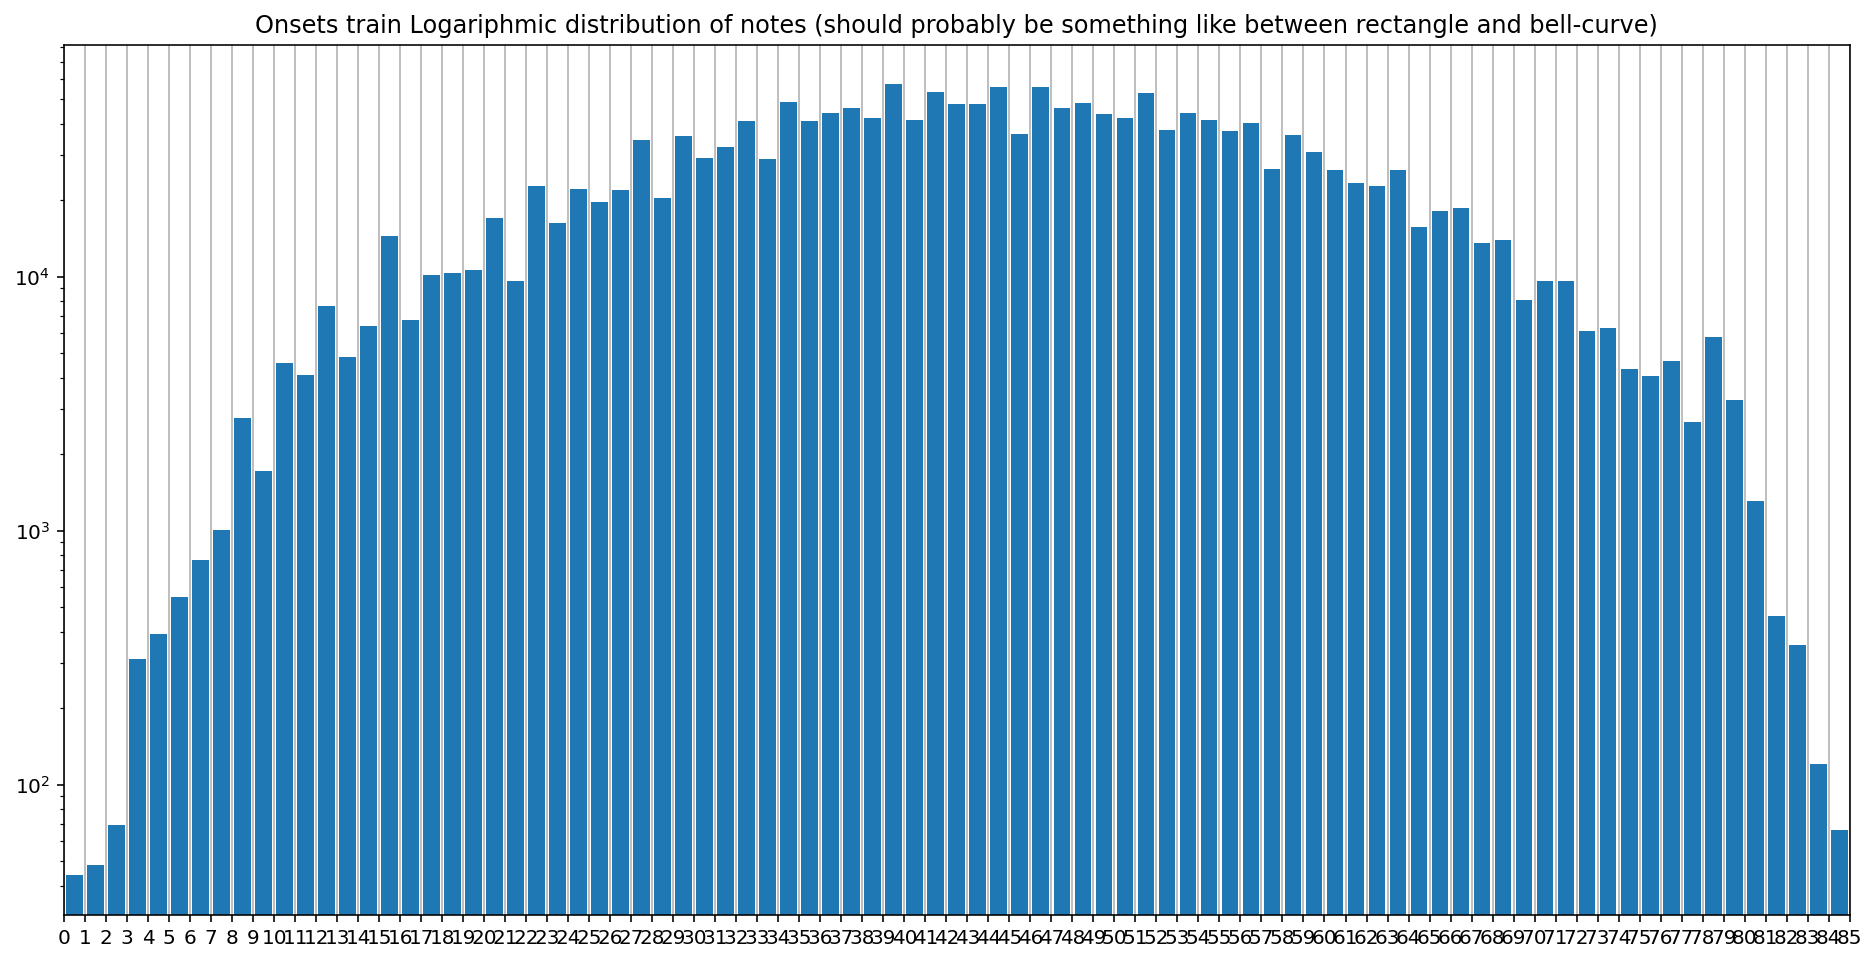

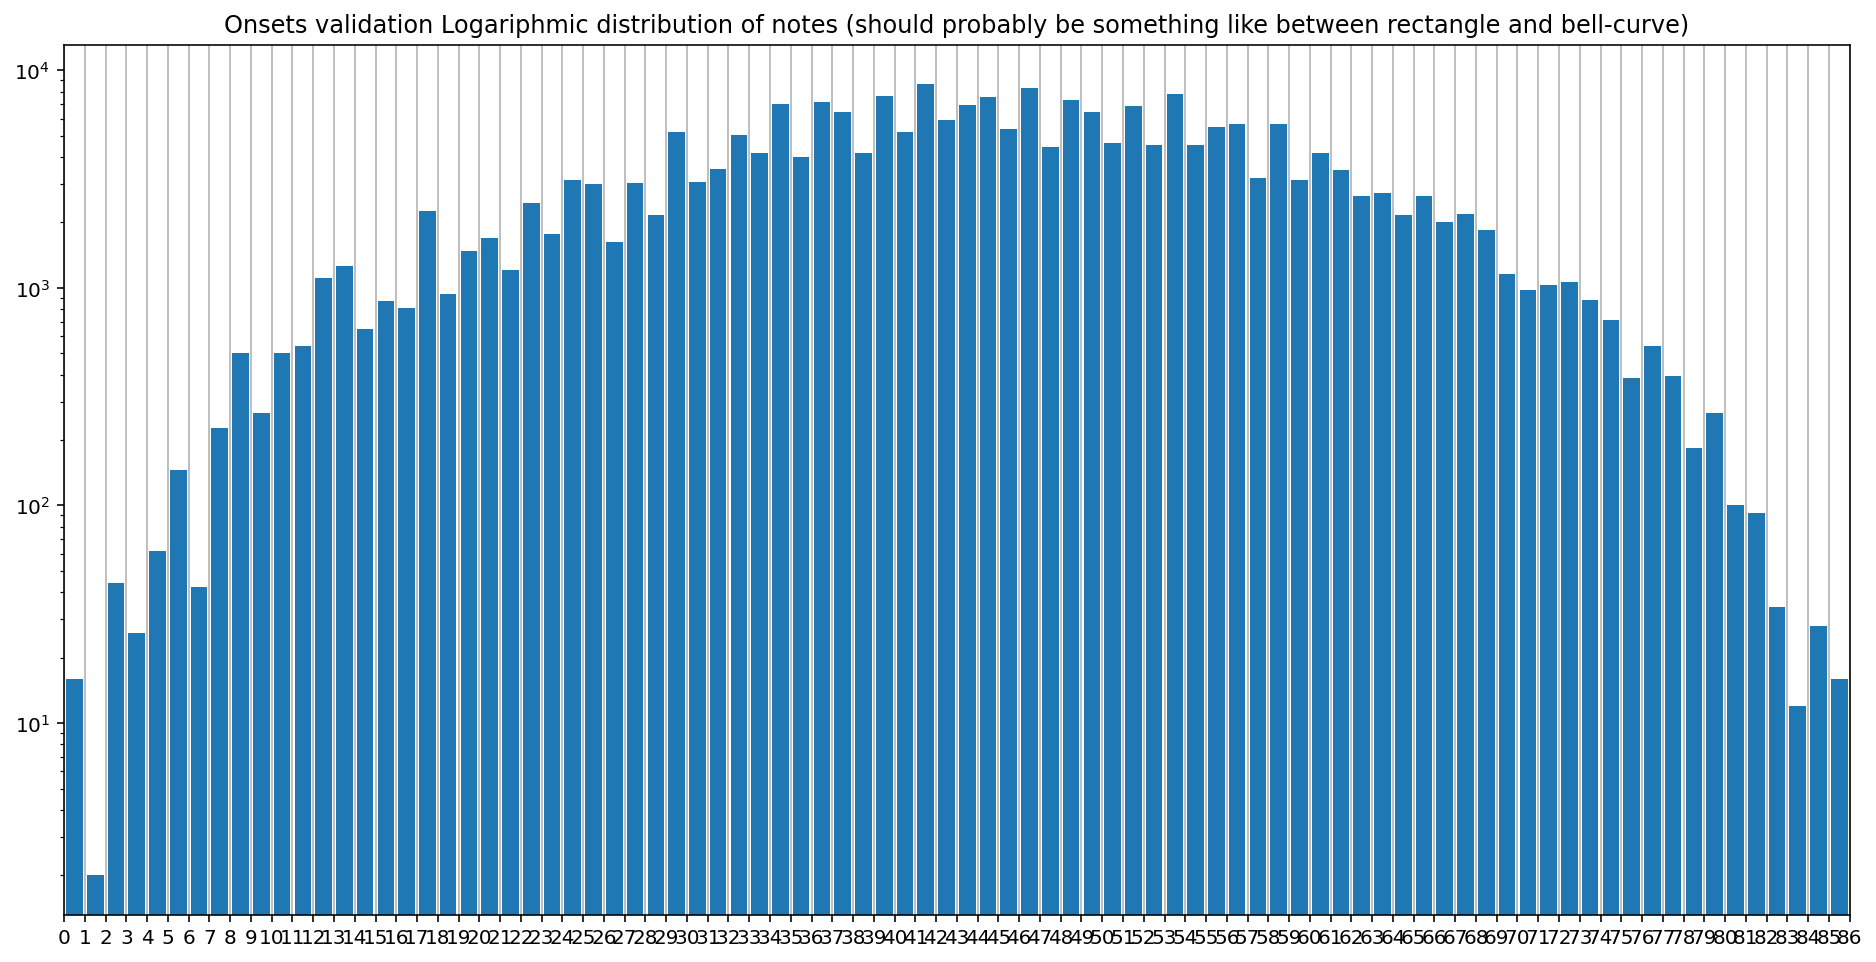

In [ ]:
def PlotNotes(name):
#    for split in ['train', 'test', 'validation']:
    for split in ['train', 'validation']:
        noteCounts = np.load('{}/{} {}.npy'.format(dataFolder, name, split)).nonzero()[2]
        minNote, maxNote = noteCounts.min(), noteCounts.max()

        plt.figure(figsize=(16, 8))
        plt.hist(noteCounts, maxNote - minNote, rwidth=.8, log=True)
        plt.title('{} {} Logariphmic distribution of notes '
                  '(should probably be something like between rectangle and bell-curve)'.format(name, split))
        plt.xlim(minNote, maxNote)
        plt.xticks(range(minNote, maxNote + 1))
        plt.grid(axis='x')

PlotNotes('Onsets')

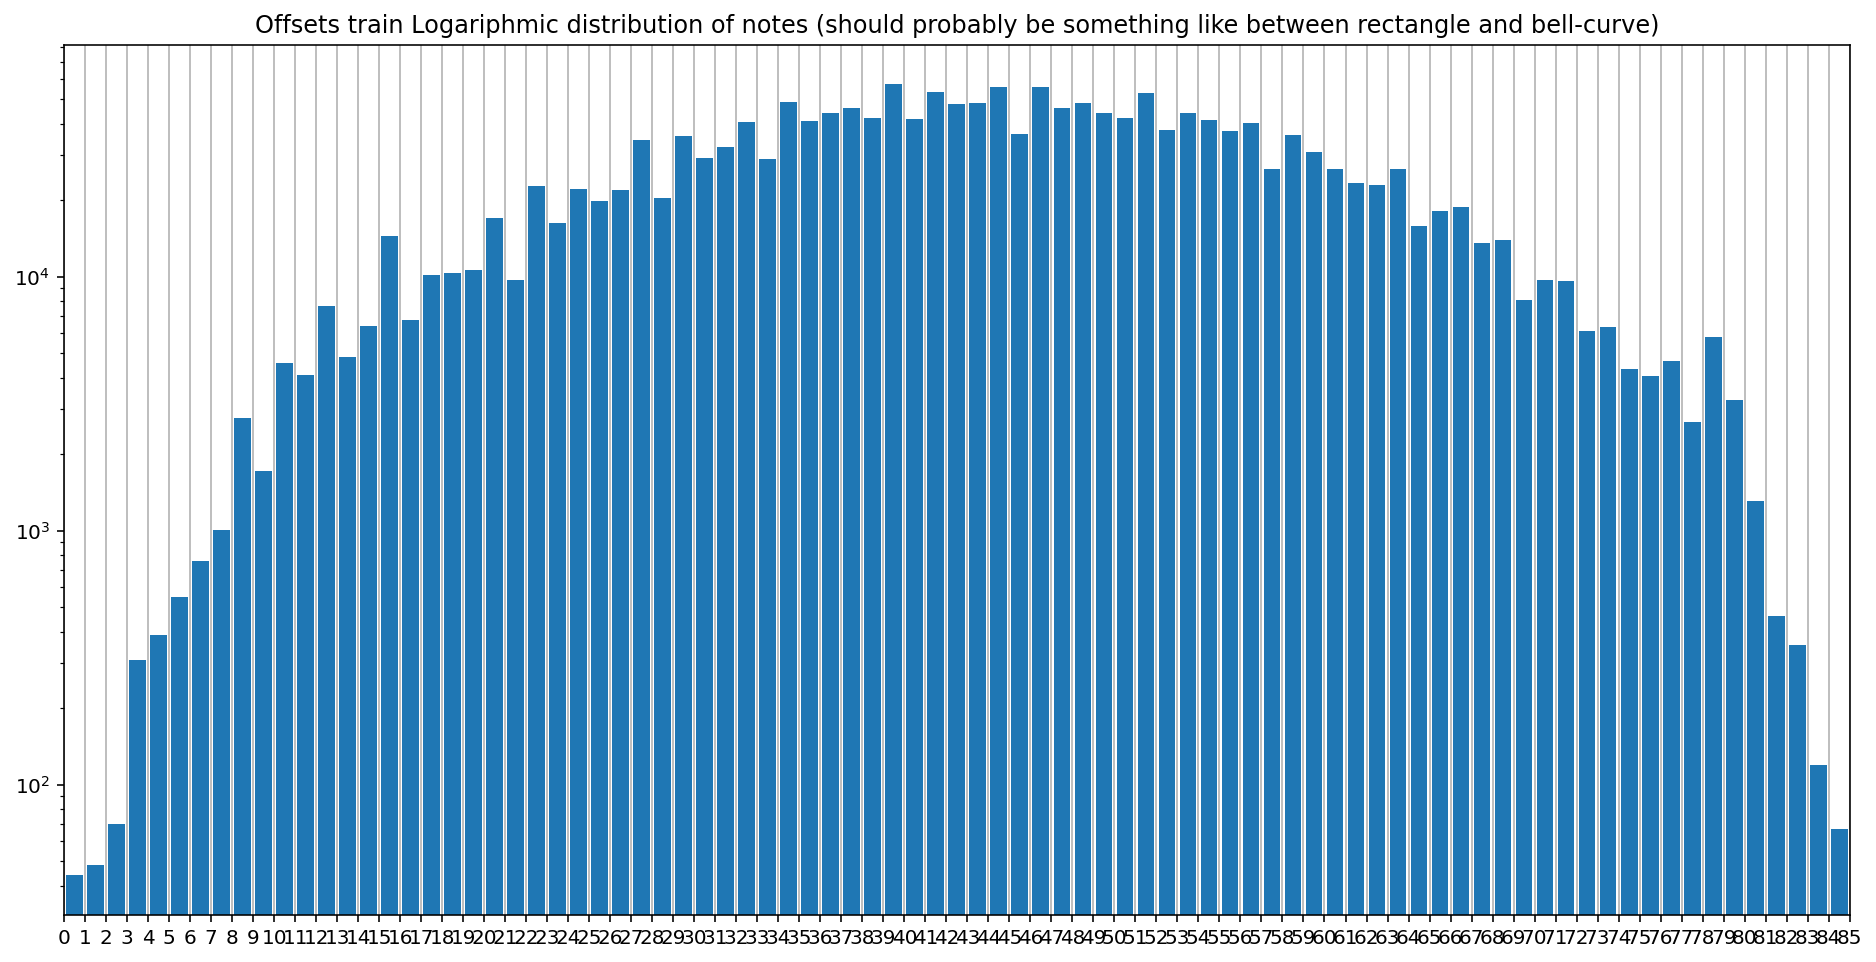

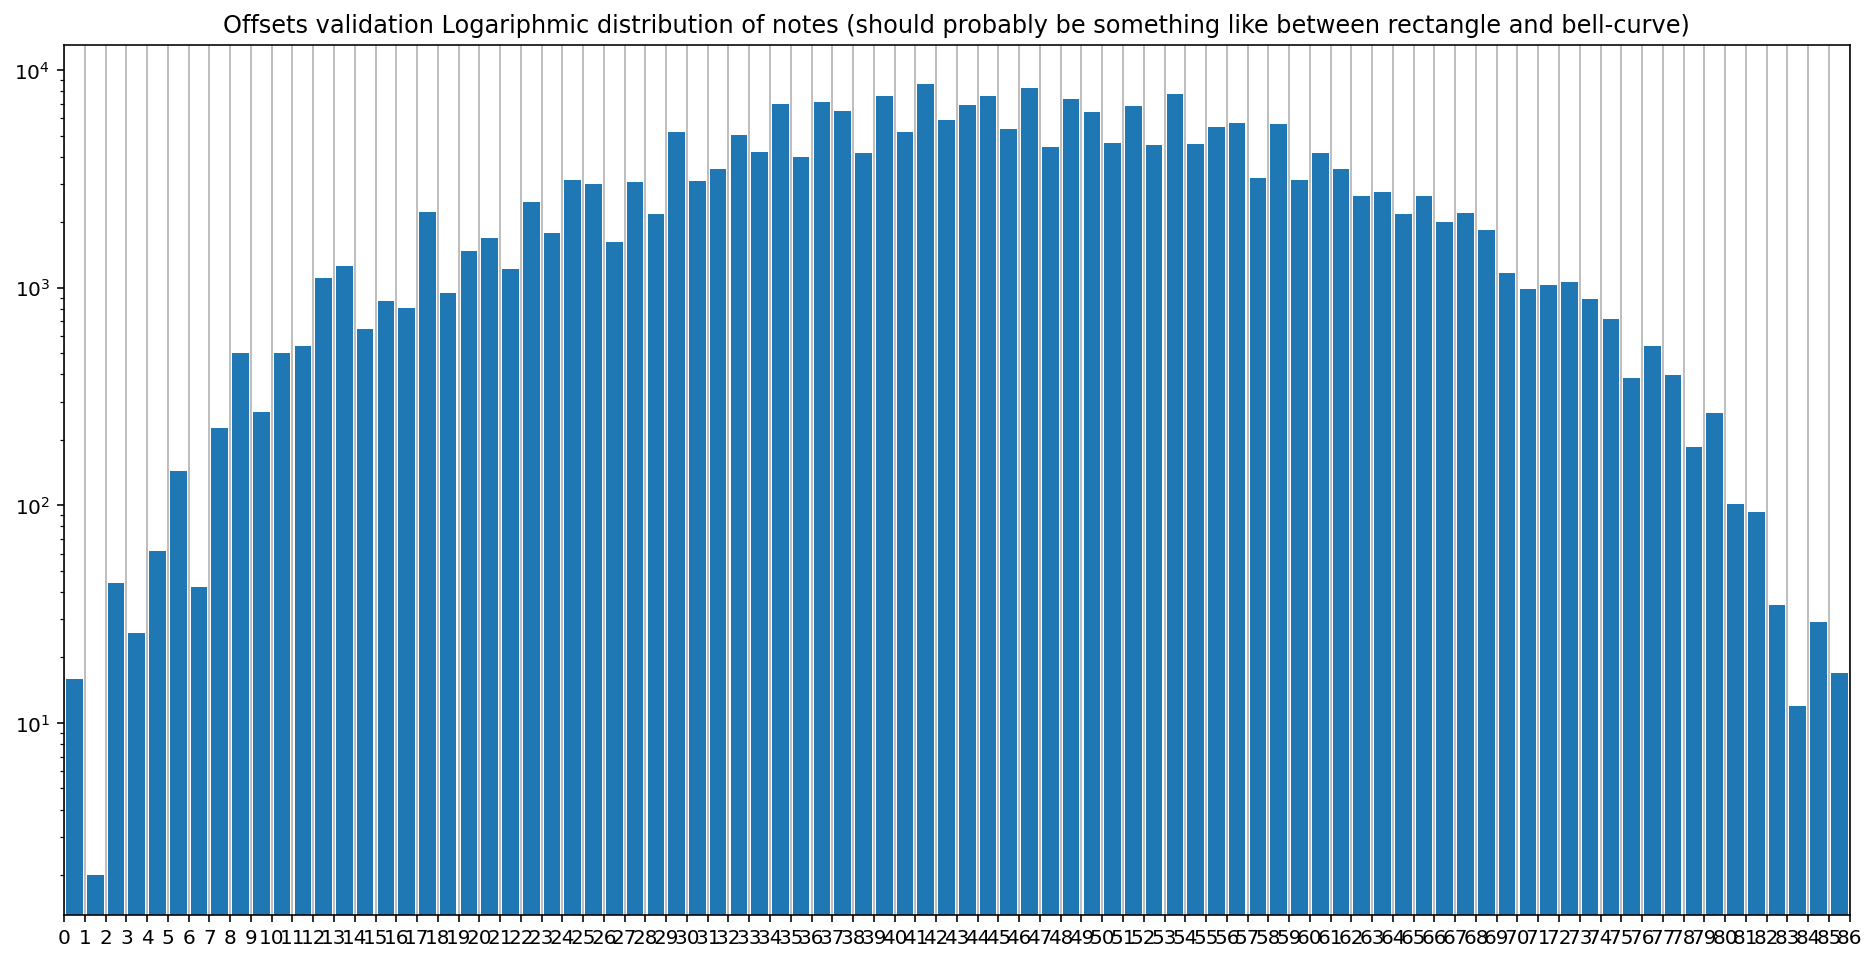

In [ ]:
PlotNotes('Offsets') # Should be the same as Onsets

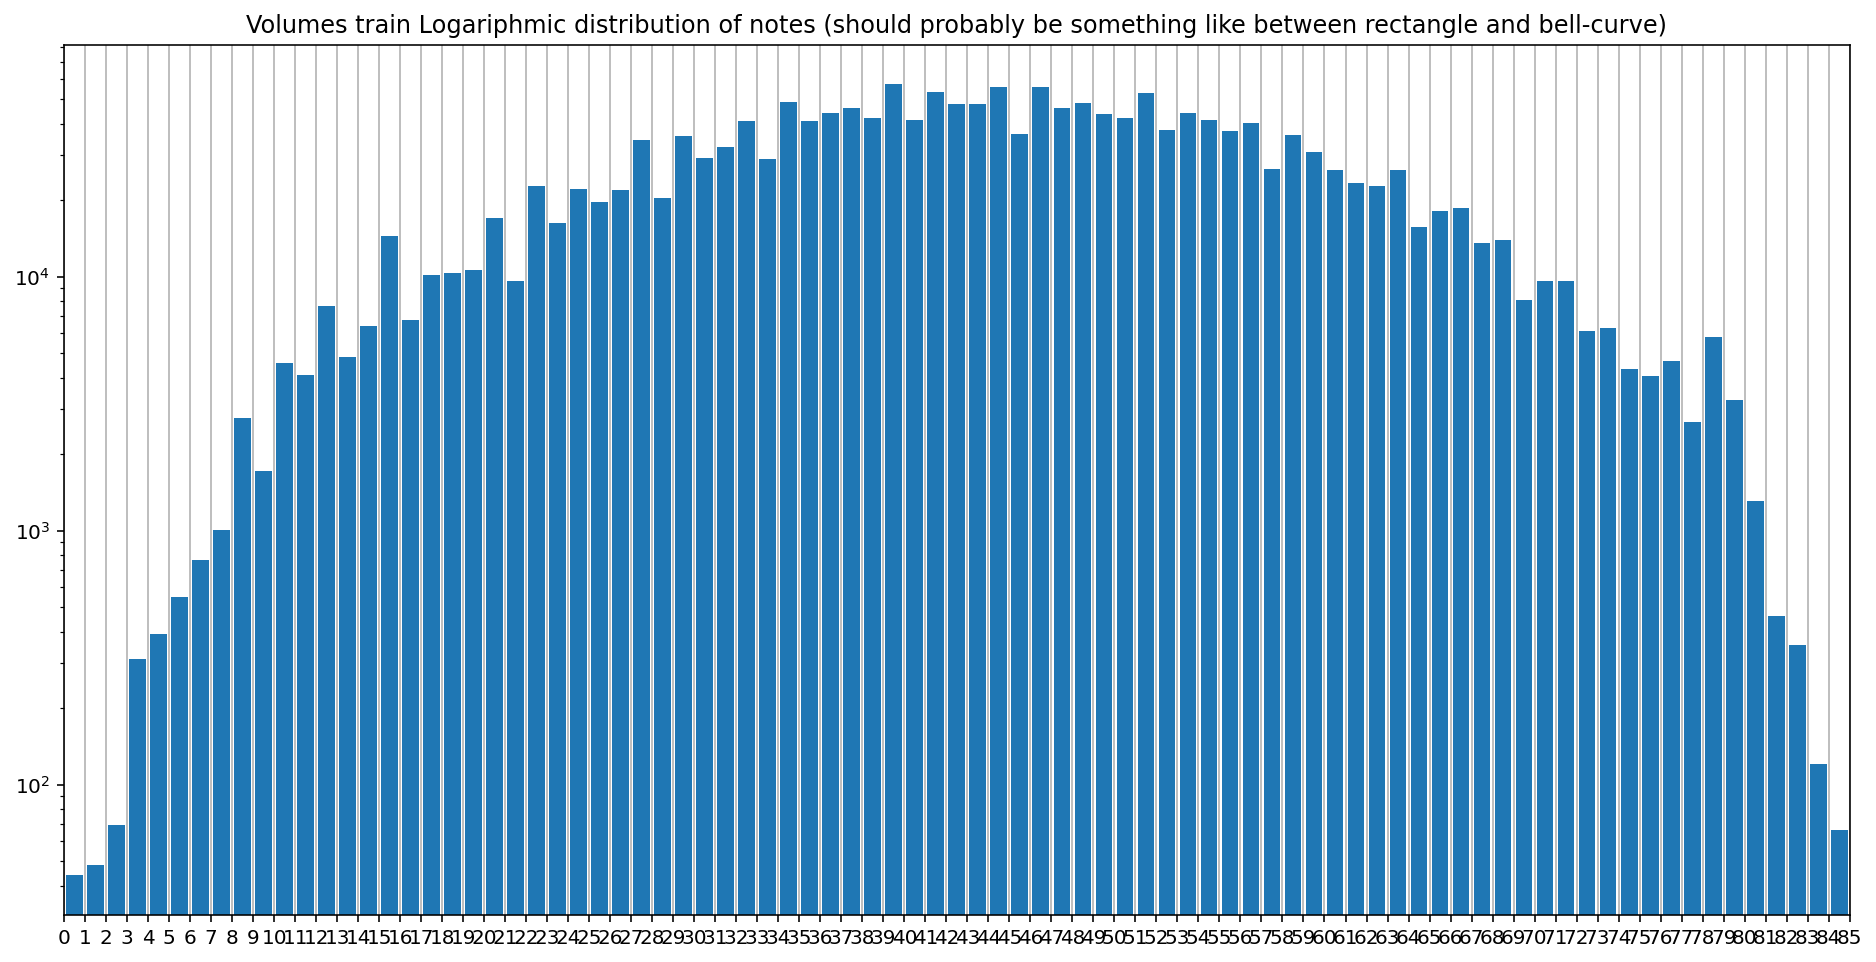

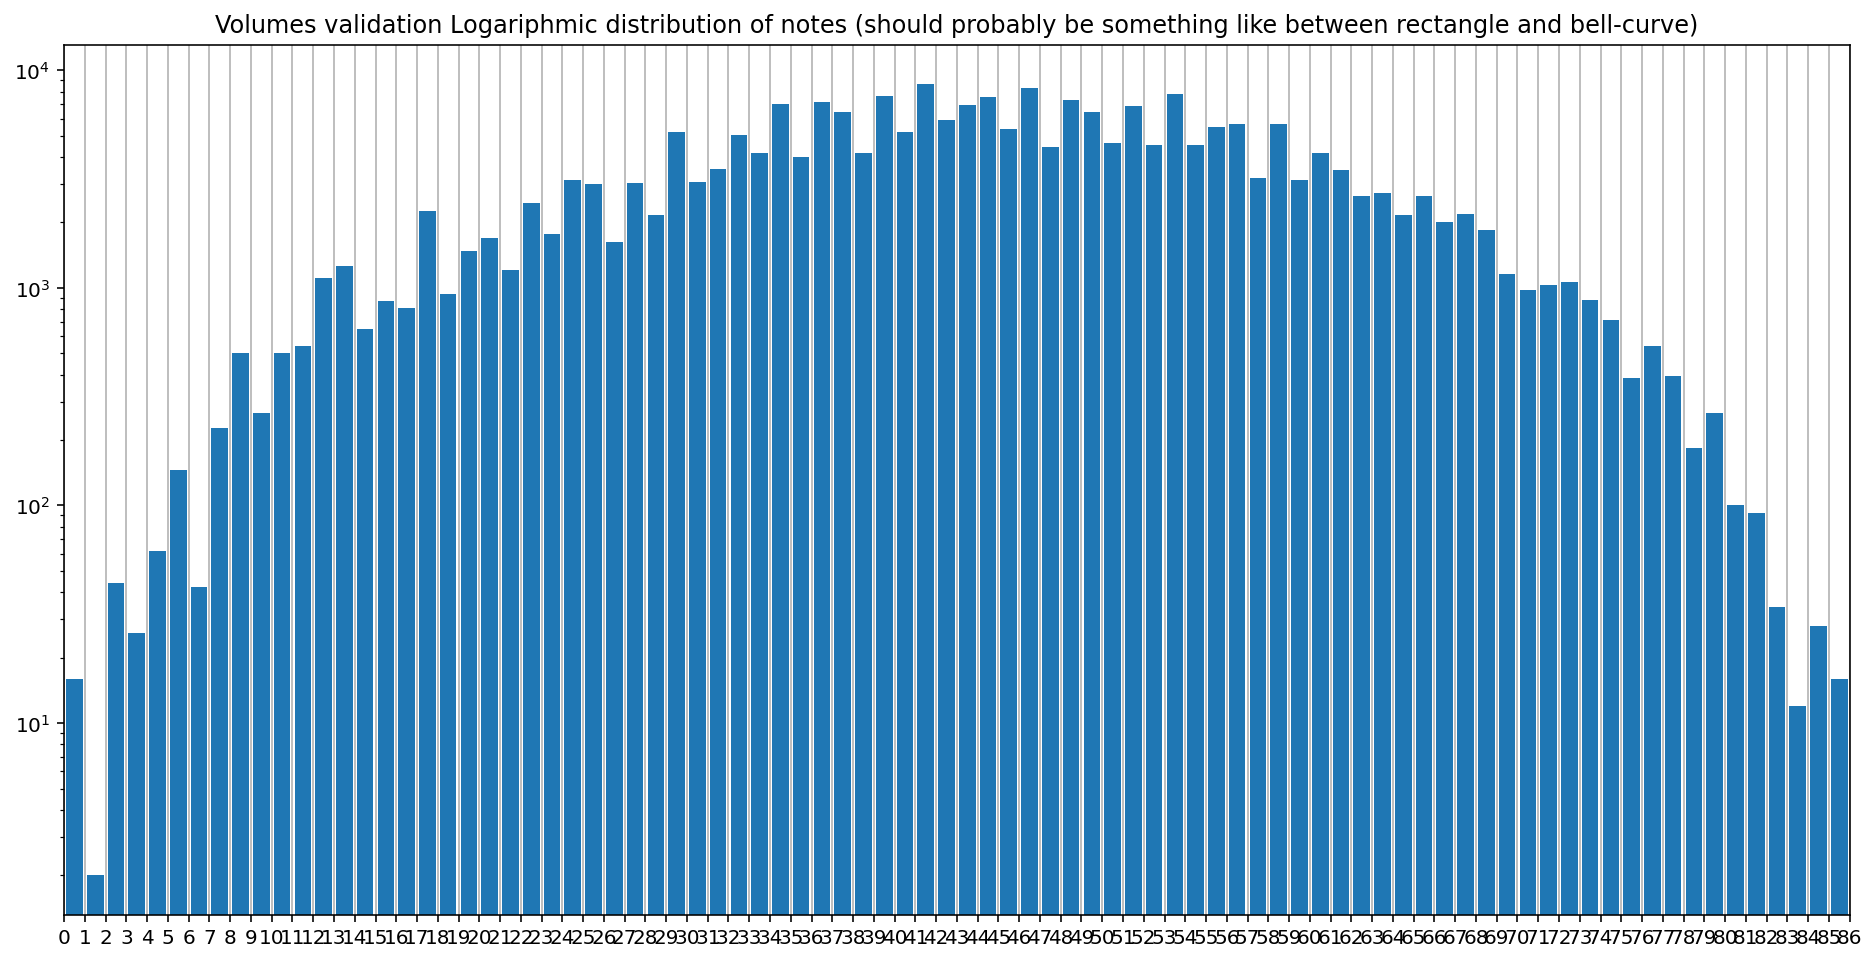

In [ ]:
PlotNotes('Volumes') # Should be the same as Onsets and Offsets

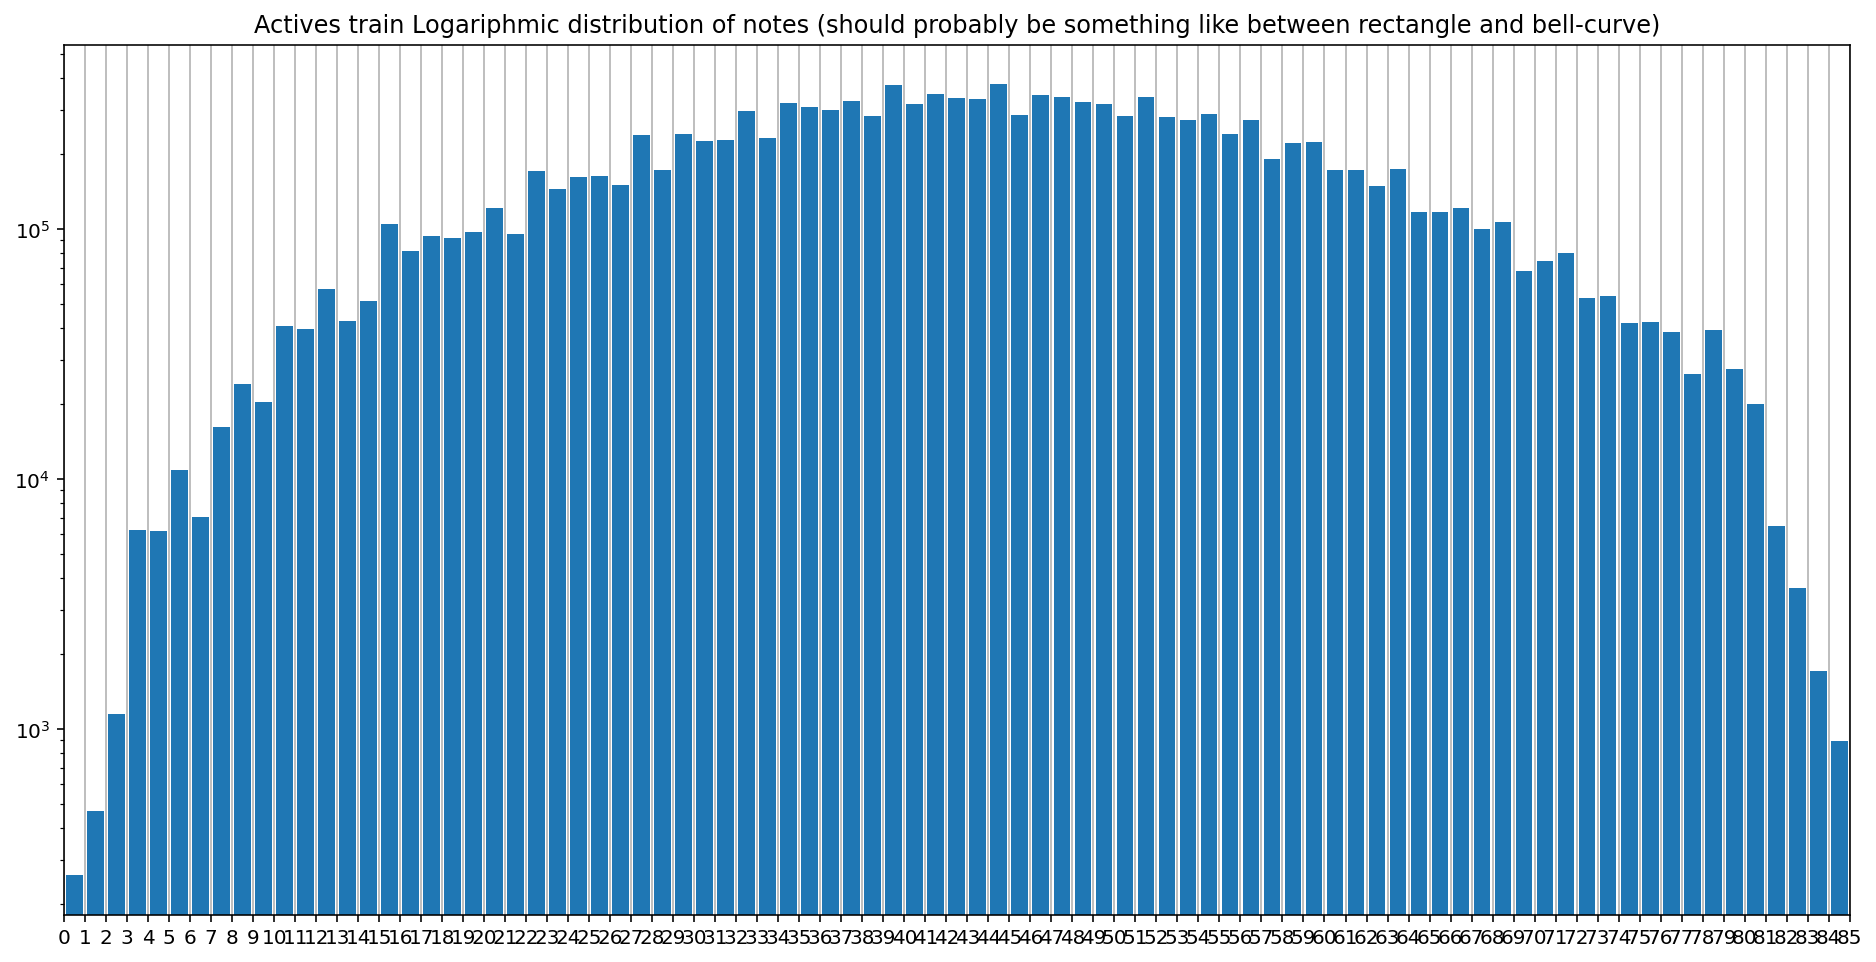

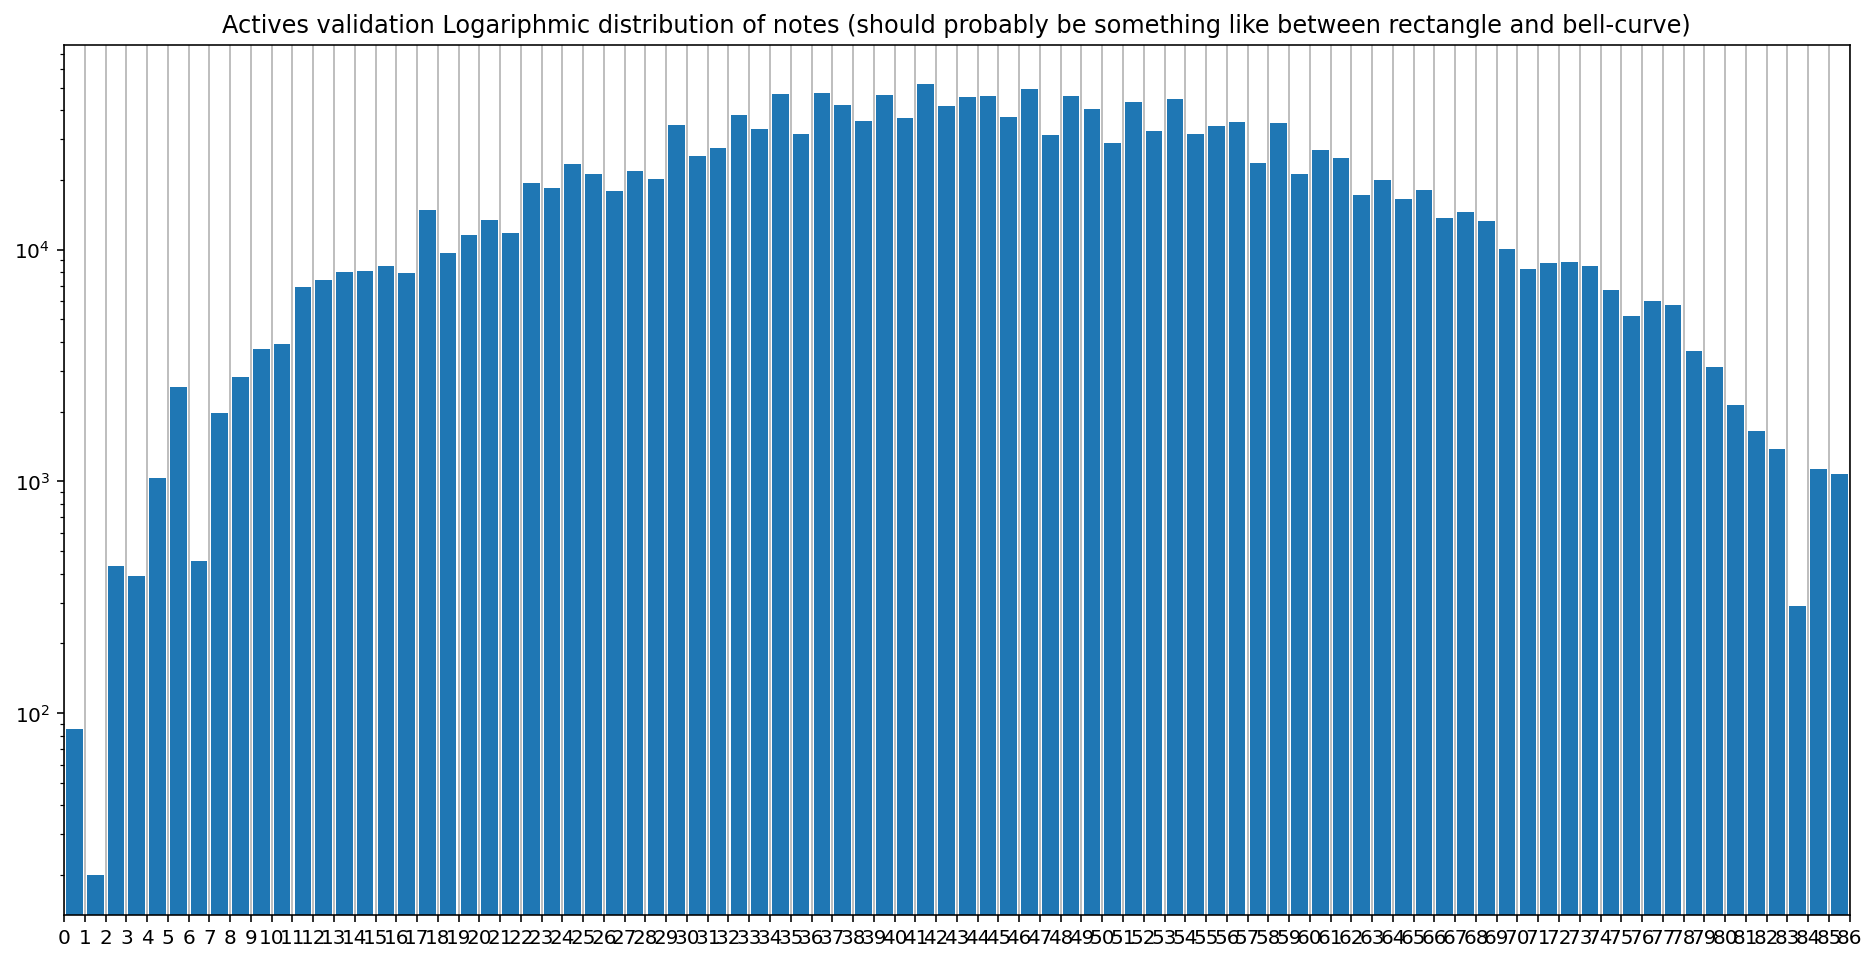

In [ ]:
PlotNotes('Actives')